In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial.distance as distance 
import scipy.cluster.hierarchy as sch 
import matplotlib.gridspec as gridspec 
import matplotlib.patches as patches
import math
import bokeh.mpl

from collections import Counter #, defaultdict

%matplotlib inline

In [3]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [4]:
# [edge for edge in G.edges(data=True) if edge[2]['edge_type'] == 'reassortant']

In [5]:
# Check to make sure that reassortant viruses do not have transmission edges going into them.
reassortant_viruses = set(edge[1] for edge in G.edges(data=True) if edge[2]['edge_type'] == 'reassortant')
print(len(reassortant_viruses))
for v in reassortant_viruses:
    for edge in G.in_edges(v, data=True):
        if edge[2]['edge_type'] == 'full_complement':
            print(v) #should not print anything

2017


In [6]:
def normalize_counter(counter):
    total = sum(counter.values())
    
    normalized = dict()
    for k, v in counter.items():
        normalized[k] = float(v) / float(total)
    return normalized

In [7]:
"""
Code that normalizes the in-edge counts to 1.0
For example, if we have a node that has 6 reassortant in_edges belonging to 3 source pair combinations that could explain its
existence, and we wanted to count the number of different subtypes that gave it its genes, we first count, and then normalize
the counter.
"""
for v in reassortant_viruses:
    in_edges = G.in_edges(v, data=True)
    sources = [s for s, _, _ in in_edges]
#     print(sources)
    
    sink_subtype = G.node[v]['subtype']
    subtype_relationship_counts = Counter()
    for source in sources:
        source_subtype = G.node[source]['subtype']
        subtype_relationship_counts[(source_subtype, sink_subtype)] += 1
        
    print(subtype_relationship_counts)

Counter({('H1N1', 'H5N1'): 1, ('H5N3', 'H5N1'): 1})
Counter({('H1N2', 'H1N1'): 1, ('H1N1', 'H1N1'): 1})
Counter({('H2N9', 'H5N2'): 1, ('H5N2', 'H5N2'): 1})
Counter({('H7N1', 'H6N2'): 1, ('H6N2', 'H6N2'): 1})
Counter({('H3N2', 'H4N2'): 1, ('H4N8', 'H4N2'): 1})
Counter({('H9N2', 'H9N2'): 1, ('H6N1', 'H9N2'): 1})
Counter({('H12N9', 'H12N5'): 1, ('H4N6', 'H12N5'): 1, ('H2N3', 'H12N5'): 1, ('H2N9', 'H12N5'): 1, ('H5N3', 'H12N5'): 1, ('H3N6', 'H12N5'): 1, ('H2N5', 'H12N5'): 1})
Counter({('H5N2', 'H5N8'): 1, ('H5N8', 'H5N8'): 1})
Counter({('H2N9', 'H2N9'): 2, ('H9N2', 'H2N9'): 1, ('Mixed', 'H2N9'): 1})
Counter({('H11N2', 'H3N2'): 1, ('H3N8', 'H3N2'): 1})
Counter({('H6N8', 'H6N8'): 1, ('H12N5', 'H6N8'): 1})
Counter({('H9N2', 'H9N2'): 1, ('H6N1', 'H9N2'): 1})
Counter({('H9N5', 'H9N6'): 4, ('H11N1', 'H9N6'): 1, ('H4N6', 'H9N6'): 1, ('H9N1', 'H9N6'): 1})
Counter({('H7N3', 'H7N9'): 1, ('H11N9', 'H7N9'): 1})
Counter({('H11N9', 'H1N9'): 1, ('H1N1', 'H1N9'): 1})
Counter({('H3N2', 'H1N2'): 1, ('H1N2',

Actually, I think the correct normalization is simply a single count of subtypes represented for each 
source, i.e. no need to normalize. This is because reassortment is a rare thing, so a single count matters.

In [8]:
# Warning: this cell takes some time to run.
subtypeG = nx.DiGraph()

for v in reassortant_viruses:
    in_edges = G.in_edges(v, data=True)
    sources = [s for s, _, _ in in_edges]
    source_subtypes = set([G.node[s]['subtype'] for s in sources])
#     print(source_subtypes)
    
    sink_subtype = G.node[v]['subtype']
    
    for source_subtype in source_subtypes:
        if (source_subtype, sink_subtype) not in G.edges():
            subtypeG.add_edge(source_subtype, sink_subtype, count=1)
        else:
            subtypeG.edge[source_subtype][sink_subtype]['count'] += 1
        
#     print(subtype_relationship_counts)

# Save the subtype graph to disk.
nx.write_gpickle(subtypeG, '07 inter-subtype interactions.pkl')

In [9]:
sorted(subtypeG.edges(data=True), key=lambda x:x[2]['count'])

[('H10N8', 'H10N8', {'count': 1}),
 ('H10N8', 'H6N8', {'count': 1}),
 ('H10N8', 'H10N2', {'count': 1}),
 ('H10N8', 'H10N4', {'count': 1}),
 ('H10N8', 'H1N3', {'count': 1}),
 ('H10N9', 'H10N1', {'count': 1}),
 ('H10N9', 'H6N1', {'count': 1}),
 ('H10N9', 'H10N3', {'count': 1}),
 ('H10N9', 'H10N9', {'count': 1}),
 ('H10N9', 'H10N7', {'count': 1}),
 ('H10N1', 'H2N1', {'count': 1}),
 ('H10N1', 'H1N1', {'count': 1}),
 ('H10N1', 'H4N1', {'count': 1}),
 ('H10N1', 'H3N8', {'count': 1}),
 ('H10N1', 'H10N1', {'count': 1}),
 ('H10N1', 'H10N7', {'count': 1}),
 ('H10N2', 'H3N8', {'count': 1}),
 ('H10N2', 'H4N2', {'count': 1}),
 ('H10N2', 'H11N2', {'count': 1}),
 ('H10N2', 'H5N2', {'count': 1}),
 ('H10N2', 'H10N8', {'count': 1}),
 ('H10N2', 'H10N9', {'count': 1}),
 ('H10N2', 'H10N1', {'count': 1}),
 ('H10N2', 'H6N2', {'count': 1}),
 ('H10N2', 'H10N3', {'count': 1}),
 ('H10N2', 'H10N7', {'count': 1}),
 ('H10N3', 'H11N3', {'count': 1}),
 ('H10N3', 'H1N3', {'count': 1}),
 ('H10N3', 'H1N1', {'count': 1})

In [10]:
sorted([(node, len(subtypeG.successors(node))) for node in subtypeG.nodes()], key=lambda x:x[1])

[('H2N6', 0),
 ('H8N8', 0),
 ('H8N2', 0),
 ('H5N6', 0),
 ('H5N4', 0),
 ('H1N7', 0),
 ('H9N3', 0),
 ('H12N2', 0),
 ('H12N3', 0),
 ('H12N1', 0),
 ('H15N4', 0),
 ('H6N4', 1),
 ('H8N1', 1),
 ('H9N6', 1),
 ('H9N8', 1),
 ('H5N7', 1),
 ('H4N7', 1),
 ('H11N6', 1),
 ('H4N4', 1),
 ('H3N7', 1),
 ('H5N8', 1),
 ('H4N5', 1),
 ('H12N6', 1),
 ('H12N7', 1),
 ('H11N7', 1),
 ('H12N9', 1),
 ('H14N6', 1),
 ('H2N4', 2),
 ('H4N1', 2),
 ('H7N5', 2),
 ('H15N9', 2),
 ('H14N2', 2),
 ('H1N8', 3),
 ('H2N8', 3),
 ('H6N9', 3),
 ('H1N6', 3),
 ('H1N5', 3),
 ('H1N4', 3),
 ('H9N7', 3),
 ('H9N9', 3),
 ('H12N4', 3),
 ('H13N6', 3),
 ('H13N2', 3),
 ('H13N9', 3),
 ('H10N5', 4),
 ('H2N5', 4),
 ('H7N2', 4),
 ('H16N3', 4),
 ('H13N8', 4),
 ('H10N8', 5),
 ('H10N9', 5),
 ('H6N7', 5),
 ('H10N1', 6),
 ('H12N8', 6),
 ('H7N6', 6),
 ('H7N4', 6),
 ('H6N3', 6),
 ('H9N5', 6),
 ('H2N7', 7),
 ('H3N3', 7),
 ('H4N9', 7),
 ('H5N9', 7),
 ('H5N5', 7),
 ('H10N6', 8),
 ('H3N5', 8),
 ('H11N8', 8),
 ('H3N9', 9),
 ('H11N1', 9),
 ('H10N2', 10),
 ('H9N

In [11]:
sorted([(node, len(subtypeG.predecessors(node))) for node in subtypeG.nodes()], key=lambda x:x[1])

[('H12N9', 0),
 ('H15N9', 0),
 ('H2N4', 2),
 ('H2N6', 2),
 ('H8N8', 2),
 ('H8N2', 2),
 ('H8N1', 2),
 ('H5N4', 2),
 ('H4N4', 2),
 ('H7N5', 2),
 ('H12N6', 2),
 ('H12N7', 2),
 ('H1N7', 2),
 ('H9N3', 2),
 ('H12N2', 2),
 ('H12N1', 2),
 ('H14N6', 2),
 ('H15N4', 2),
 ('H9N8', 3),
 ('H3N7', 3),
 ('H1N5', 3),
 ('H1N4', 3),
 ('H6N4', 4),
 ('H9N6', 4),
 ('H5N6', 4),
 ('H12N8', 4),
 ('H11N6', 4),
 ('H1N6', 4),
 ('H14N2', 4),
 ('H13N6', 4),
 ('H13N2', 4),
 ('H10N4', 5),
 ('H5N7', 5),
 ('H5N5', 5),
 ('H4N5', 5),
 ('H9N9', 5),
 ('H12N4', 5),
 ('H13N9', 5),
 ('H2N5', 6),
 ('H2N8', 6),
 ('H6N7', 6),
 ('H7N4', 6),
 ('H16N3', 6),
 ('H1N8', 7),
 ('H5N8', 7),
 ('H1N9', 7),
 ('H6N3', 7),
 ('H9N5', 7),
 ('H11N1', 7),
 ('H13N8', 7),
 ('H4N9', 8),
 ('H4N3', 8),
 ('H7N9', 8),
 ('H6N6', 8),
 ('H10N9', 9),
 ('H10N3', 9),
 ('H3N9', 9),
 ('H6N9', 9),
 ('H11N8', 9),
 ('H2N9', 10),
 ('H3N5', 10),
 ('H7N8', 10),
 ('H7N6', 10),
 ('H1N3', 10),
 ('H9N7', 10),
 ('H11N7', 10),
 ('H12N3', 10),
 ('H10N6', 11),
 ('H2N1', 11),

In [12]:
centralities = pd.DataFrame(sorted(nx.degree_centrality(subtypeG).items(), key=lambda x:x[1]))
centralities.columns = ['Subtype', 'Degree Centrality']
centralities.to_csv('Subtype Reassortment Centralities.csv')

In [13]:
def clean_axis(ax):
    """Remove ticks, tick labels, and frame from axis"""
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

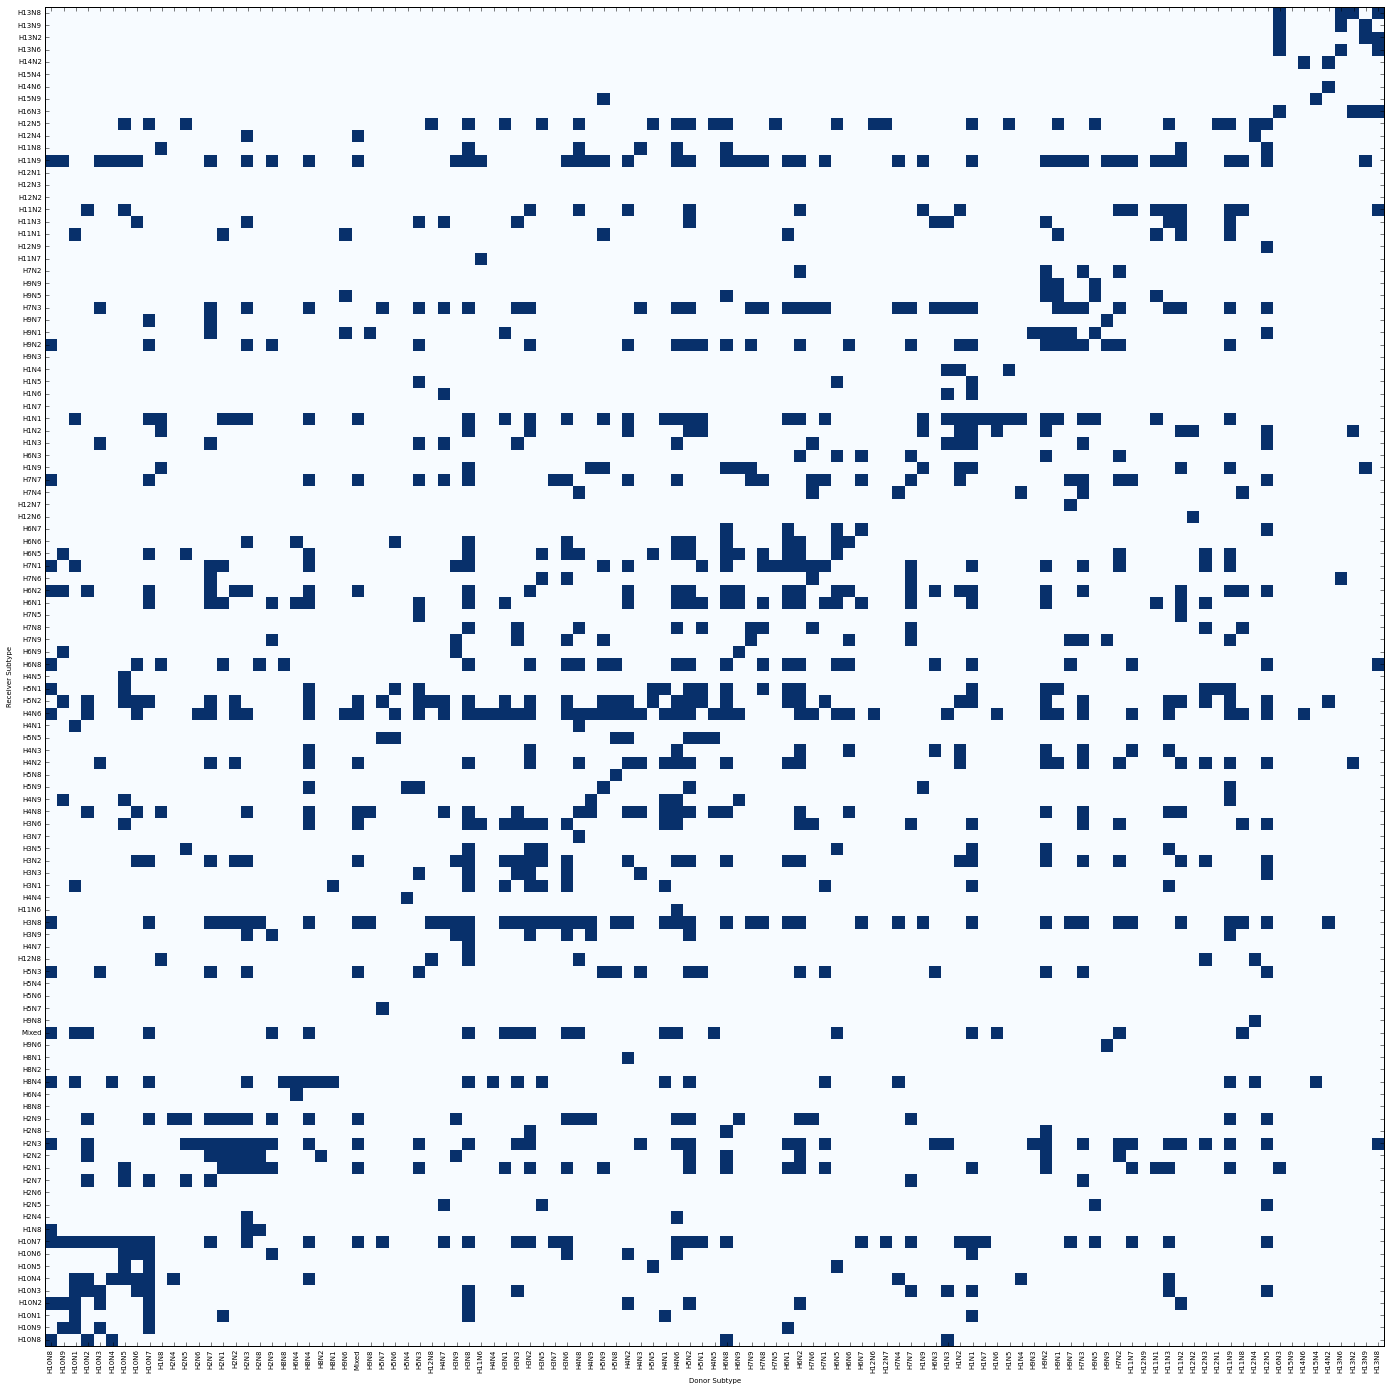

In [14]:
# This cell doesn't do much better compared to the one above it.
A = nx.to_numpy_matrix(subtypeG, weight='count')
A = pd.DataFrame(A)

A.columns = subtypeG.nodes()
A.index = subtypeG.nodes()
fig = plt.figure(figsize=(24,24))
heatmap = plt.pcolor(A, cmap='Blues')
# heatmap.set_clim(vmin=0, vmax=10)
plt.axes().set_aspect('equal')
plt.xticks(range(0, len(A.index)), A.index, rotation=90)
plt.yticks(range(0, len(A.columns)), A.columns)
plt.axes().set_xticks(np.arange(len(A.columns))+0.5)
plt.axes().set_yticks(np.arange(len(A.index))+0.5)
plt.xlim(0,len(subtypeG.nodes()))
plt.ylim(0,len(subtypeG.nodes()))
plt.xlabel('Donor Subtype')
plt.ylabel('Receiver Subtype')
plt.show()

Number of rows: 109
Size of distance matrix: (109, 109)


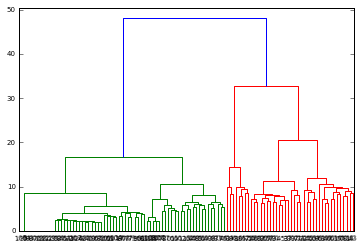

In [15]:
pairwise_dists = distance.squareform(distance.pdist(A))
print 'Number of rows: {0}'.format(A.shape[0])
print 'Size of distance matrix: {0}'.format(pairwise_dists.shape) 
row_clusters = sch.linkage(pairwise_dists,method='complete')
den = sch.dendrogram(row_clusters) 

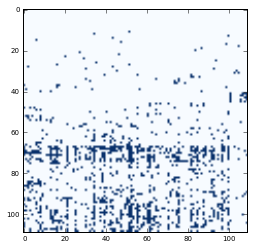

In [16]:
plt.imshow(A.ix[den['leaves']], cmap='Blues')

/Users/ericmjl/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


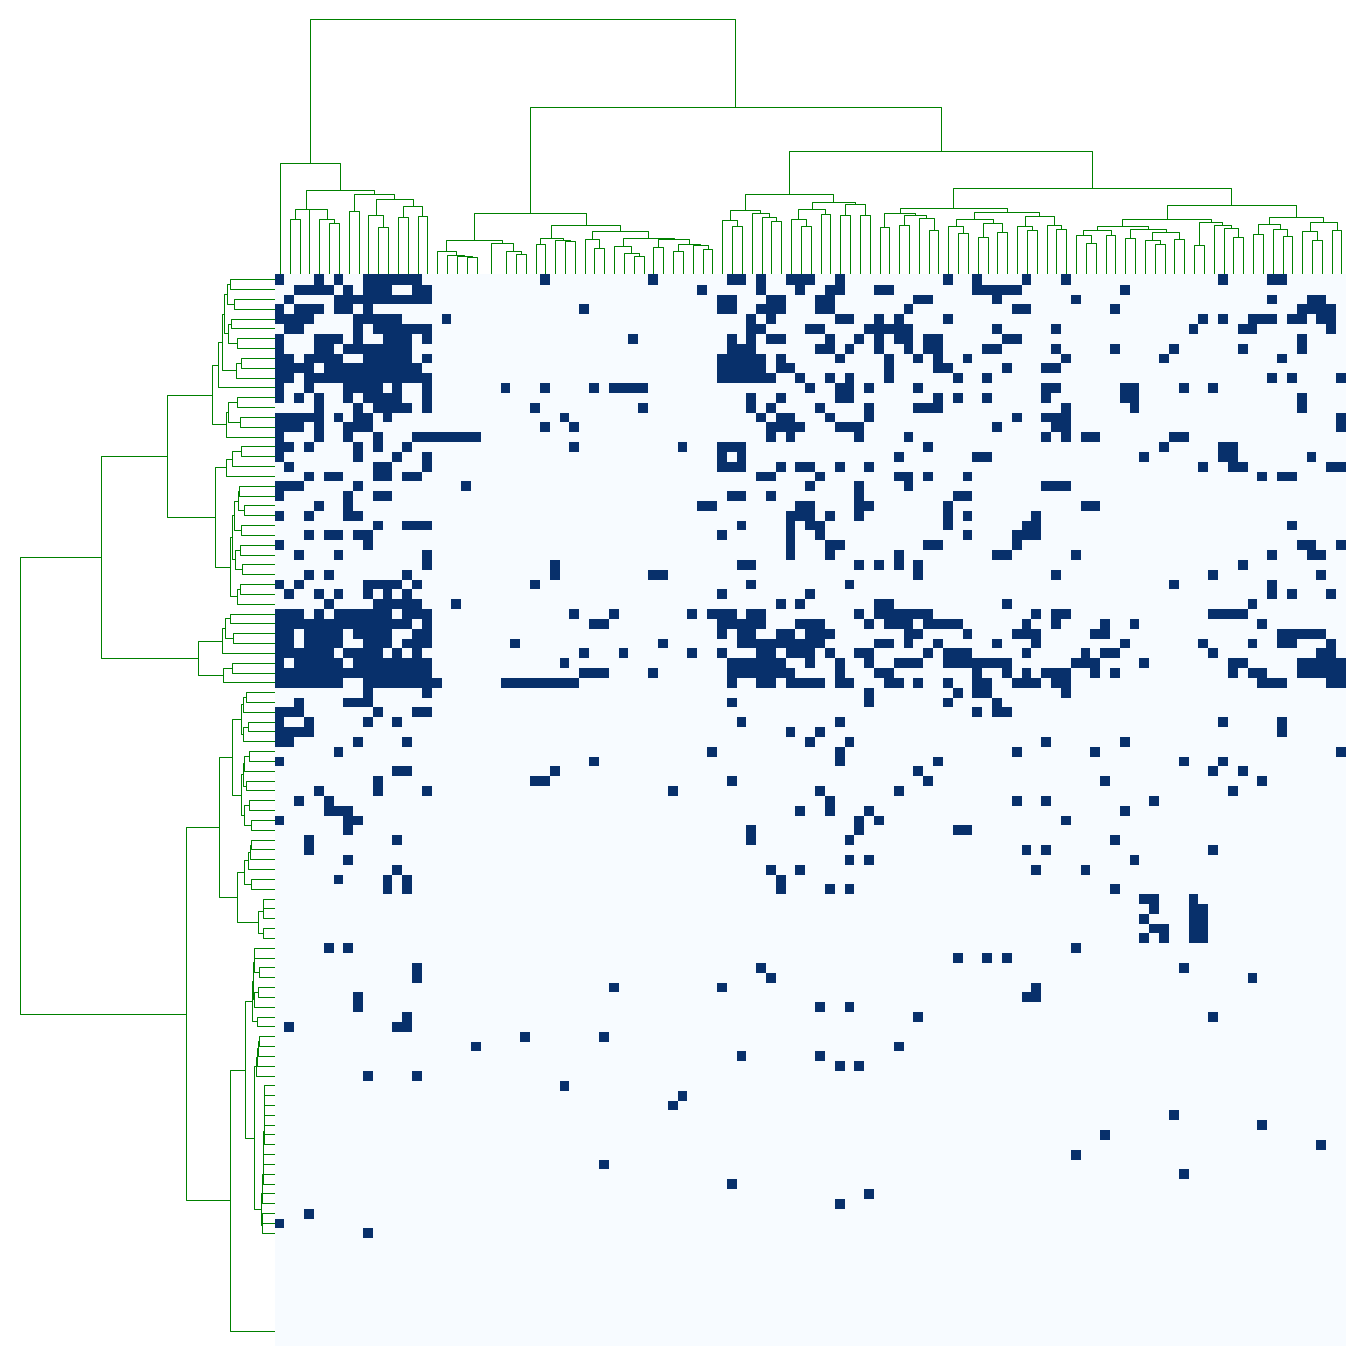

In [17]:
col_pairwise_dists = distance.squareform(distance.pdist(A.T))
# cluster
col_clusters = sch.linkage(col_pairwise_dists,method='complete')

fig = plt.figure(figsize=(24,24))
heatmapGS = gridspec.GridSpec(2,2,wspace=0.0,hspace=0.0,width_ratios=[0.25,1],height_ratios=[0.25,1])

### col dendrogram ####
col_denAX = fig.add_subplot(heatmapGS[0,1])
col_denD = sch.dendrogram(col_clusters,color_threshold=np.inf)
clean_axis(col_denAX)

### row dendrogram ###
row_denAX = fig.add_subplot(heatmapGS[1,0])
row_denD = sch.dendrogram(row_clusters,color_threshold=np.inf,orientation='right')
clean_axis(row_denAX)

### heatmap ###
heatmapAX = fig.add_subplot(heatmapGS[1,1])
axi = heatmapAX.pcolor(A.ix[den['leaves'],col_denD['leaves']],cmap='Blues')
plt.xlim(0, len(A.index))
plt.ylim(0, len(A.columns))
clean_axis(heatmapAX)


### set labels ###
# heatmapAX.set_xticks(np.arange(A.shape[1])+0.5)
# xlabels = A.columns[col_denD['leaves']]
# heatmapAX.set_xticklabels(xlabels, rotation=90)

# heatmapAX.set_yticks(np.arange(A.shape[0])+0.5)
# ylabels = A.columns[row_denD['leaves']]
# heatmapAX.yaxis.set_ticks_position('right')
# heatmapAX.set_yticklabels(ylabels)


### remove tick lines ###
for l in heatmapAX.get_xticklines() + heatmapAX.get_yticklines(): 
    l.set_markersize(0)
 

plt.savefig('Inter-Subtype Connectivity.pdf', bbox_inches='tight')

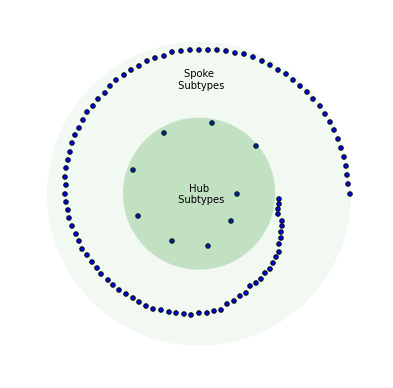

In [18]:
# Programatically create the snail shell plot.

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
node_fs = 10


# circle = plt.Circle((0, 0), 1, transform=ax.transData._b, color="red", alpha=0.4)
# ax.add_artist(circle) 

# Add the "spoke" circle
circle = plt.Circle((0,0), radius=1, transform=ax.transData._b, linewidth=0, color='green', alpha=0.05)

hub_thresh = 0.5

ax.add_artist(circle)
# Add the "hub" circle
circle = plt.Circle((0,0), radius=1 - hub_thresh, transform=ax.transData._b, linewidth=0, color='green', alpha=0.2)
ax.add_artist(circle)



for group, data in centralities.groupby(centralities['Degree Centrality'] > hub_thresh):
    for row, series in data.iterrows():
        theta = float(row) / len(data) * 2 * math.pi
        if series['Degree Centrality'] > hub_thresh:
            radius = 1 - series['Degree Centrality'] #preserves scalings
            # radius = 1 - math.sqrt(series['Degree Centrality']) #accentuates hub/spoke status
            # radius = 0.3
        if series['Degree Centrality'] <= hub_thresh:
            # radius = 1 - series['Degree Centrality'] ** 2 #accentuates hub/spoke status
            radius = 1 - series['Degree Centrality'] #preserves scalings
            # radius = 1
            # ax.plot([theta, theta], [0.5, 1], color='black', linestyle=':')

        ax.scatter(theta, radius)
    
# ax.set_yticks(np.arange(1,0)) 
# ax.set_xticks(ax.get_xticks(), ['' * len(ax.get_xticks())])
ax.annotate('Hub \n Subtypes', xy=(0,0), ha='center', va='center')
ax.annotate('Spoke \n Subtypes', xy=(math.pi/2, hub_thresh+(1-hub_thresh)/2), ha='center', va='center')
ax.axis('off')
plt.savefig('Hub and Spoke.pdf', bbox_inches='tight')

In [19]:
centralities

,Subtype,Degree Centrality
0,H12N9,0.009259
1,H2N6,0.018519
2,H8N8,0.018519
3,H8N2,0.018519
4,H5N4,0.018519
5,H1N7,0.018519
6,H9N3,0.018519
7,H12N2,0.018519
8,H12N1,0.018519
9,H15N9,0.018519


In [20]:
nodes = sorted(nx.degree_centrality(subtypeG).items(),  key=lambda x:x[1])
nodes = [i[0] for i in nodes]
nodes

['H12N9',
 'H2N6',
 'H8N8',
 'H8N2',
 'H5N4',
 'H1N7',
 'H9N3',
 'H12N2',
 'H12N1',
 'H15N9',
 'H15N4',
 'H8N1',
 'H4N4',
 'H12N6',
 'H12N7',
 'H14N6',
 'H2N4',
 'H3N7',
 'H5N6',
 'H7N5',
 'H9N8',
 'H9N6',
 'H6N4',
 'H11N6',
 'H5N7',
 'H4N5',
 'H1N5',
 'H1N4',
 'H14N2',
 'H1N6',
 'H13N6',
 'H13N2',
 'H5N8',
 'H9N9',
 'H12N4',
 'H13N9',
 'H2N8',
 'H1N8',
 'H2N5',
 'H12N8',
 'H12N3',
 'H16N3',
 'H11N7',
 'H6N7',
 'H13N8',
 'H4N7',
 'H5N5',
 'H6N9',
 'H7N4',
 'H6N3',
 'H9N7',
 'H9N5',
 'H10N9',
 'H4N1',
 'H4N9',
 'H10N4',
 'H7N6',
 'H11N1',
 'H11N8',
 'H10N5',
 'H3N9',
 'H3N5',
 'H10N1',
 'H10N6',
 'H4N3',
 'H7N2',
 'H5N9',
 'H7N9',
 'H6N6',
 'H1N9',
 'H10N3',
 'H7N8',
 'H10N8',
 'H1N3',
 'H9N1',
 'H3N1',
 'H3N3',
 'H10N2',
 'H2N2',
 'H2N7',
 'H11N3',
 'H1N2',
 'H5N1',
 'H2N9',
 'H5N3',
 'H6N5',
 'H2N1',
 'H11N2',
 'H7N1',
 'Mixed',
 'H7N7',
 'H3N6',
 'H4N8',
 'H8N4',
 'H4N2',
 'H6N1',
 'H3N2',
 'H6N8',
 'H9N2',
 'H12N5',
 'H7N3',
 'H2N3',
 'H10N7',
 'H6N2',
 'H1N1',
 'H5N2',
 'H11N9',
 '

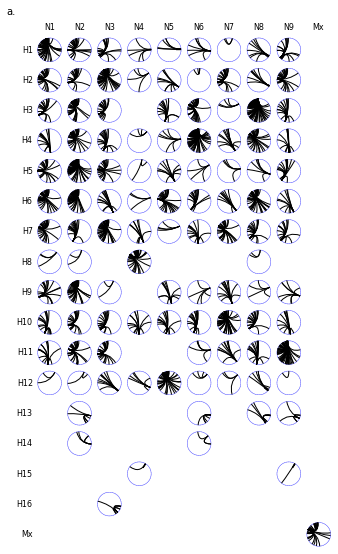

In [21]:
# Make a Circos panel for all of the subtypes.
%load_ext autoreload
%autoreload 2
from circos import CircosPlot

fig = plt.figure(figsize=(4.5, 7.5))
# Annotate the figure with NA subtype labels
for na in range(1,11):
    ax = plt.subplot2grid((18, 11), (0, na))
    if na == 10:
        ax.annotate('Mx'.format(na), xy=(0.5, 0), va='bottom', ha='center', xycoords='axes fraction', fontsize=8)
    else:
        ax.annotate('N{0}'.format(na), xy=(0.5, 0), va='bottom', ha='center', xycoords='axes fraction', fontsize=8)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for k in ax.spines.keys():
        ax.spines[k].set_visible(False)
        
    ax.set_aspect('equal')

# Annotate the figure with HA subtype labels
for ha in range(1,18):
    ax = plt.subplot2grid((18, 11), (ha, 0))
    if ha == 17:
        ax.annotate('Mx'.format(ha), xy=(1, 0.5), va='center', ha='right', xycoords='axes fraction', fontsize=8)
    else:
        ax.annotate('H{0}'.format(ha), xy=(1, 0.5), va='center', ha='right', xycoords='axes fraction', fontsize=8)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for k in ax.spines.keys():
        ax.spines[k].set_visible(False)
    ax.set_aspect('equal')
        
# Plot the circos plots for each subtype
subtypes_considered = []
for node in subtypeG.nodes():
    if node != 'Mixed':
        ha = int(node.split('N')[0].split('H')[1])
        na = int(node.split('N')[1])
        ax = plt.subplot2grid((18, 11), (ha, na))
    if node == 'Mixed':
        ax = plt.subplot2grid((18, 11), (17, 10))
    
    nodes = sorted(nx.degree_centrality(subtypeG).items(),  key=lambda x:x[1])
    nodes = [i[0] for i in nodes]
    edges = [(u, v) for u,v in subtypeG.edges() if node in [u, v] and u != v]
    c = CircosPlot(nodes, edges, radius=1, nodecolor='blue', figsize=(1,1), fig=fig, ax=ax)
    c.draw()
    ax.set_aspect('equal')

# Add in one final axes to indicate that this is figure panel (a).
ax = plt.subplot2grid((18, 11), (0,0))
ax.annotate('a.', xy=(0,1), xycoords='axes fraction', ha='left', va='top')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for k in ax.spines.keys():
    ax.spines[k].set_visible(False)
# Save the figure
plt.subplots_adjust(left=0, right=1.0, bottom=0, top=1.0)
plt.savefig('Inter-Subtype Connectivity Circos.pdf')

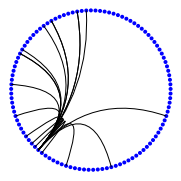

In [22]:
# Make one example figure with one circos plot.
subtype_of_interest = 'H7N9'

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
nodes = sorted(nx.degree_centrality(subtypeG).items(),  key=lambda x:x[1])
nodes = [i[0] for i in nodes]
edges = [(u, v) for u,v in subtypeG.edges() if subtype_of_interest in [u, v] and u != v]
c = CircosPlot(nodes, edges, radius=1, nodecolor='blue', figsize=(1,1), fig=fig, ax=ax)
c.draw()
ax.set_aspect('equal')

plt.savefig('Circos Example - H7N9.pdf')